In [75]:
import pickle as pkl
import numpy as np
import pandas as pd
import json
import sklearn
from sklearn import * 
from matplotlib import pyplot as plt

In [76]:
df = pd.read_pickle("saved_runs/2023-04-24.1/History.pkl")
print(df)

    Node_id  Parent_id  Time   
0         0        NaN     0  \
1         1        0.0     1   
2         2        0.0     1   
3         3        2.0     2   
4         4        2.0     2   
5         5        4.0     3   
6         6        4.0     3   
7         7        3.0     3   
8         8        3.0     3   
9         9        1.0     2   
10       10        1.0     2   
11       11       10.0     3   
12       12       10.0     3   
13       13        9.0     3   
14       14        9.0     3   

                                                State   
0   [[4.000000010126242, 4.000007735862576], [2.00...  \
1   [[4.000615400596871, 7.45572377126814], [3.821...   
2   [[4.000000010126242, 4.000007735862576], [2.00...   
3   [[4.418522370993742, 7.496601534563524], [3.29...   
4   [[4.000000010126242, 4.000007735862576], [2.00...   
5   [[24.31794739782007, 4.000000010499953], [2.00...   
6   [[4.000000010126242, 4.000007735862576], [2.00...   
7   [[4.0000010551052325, 4.001

In [77]:
states = df.State.to_list()
states = np.array(states)
states.shape

(15, 14, 2)

In [78]:
states = df.State.to_list()
states = np.array(states)
states[np.isnan(states)] = 0
statesA = states[:,:,0]
statesB = states[:,:,1]
numStates = np.shape(statesA)[0]
np.sum(np.isnan(states))

0

In [79]:
# states

In [ ]:
pca_fit_ra

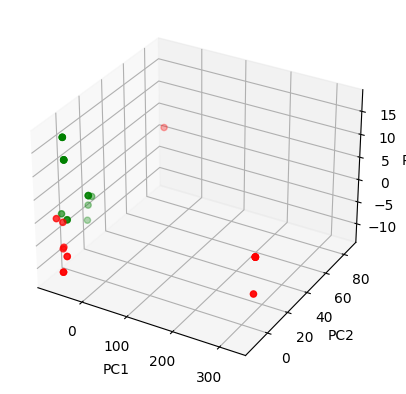

In [80]:

pca = sklearn.decomposition.PCA(3)
pca_fit_AB = pca.fit_transform(np.concatenate((statesA,statesB),0))
pca_fit_A = pca_fit_AB[:numStates,:]
pca_fit_B = pca_fit_AB[numStates:,:]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pca_fit_A[:,0], pca_fit_A[:,1], pca_fit_A[:,2], color="green")
ax.scatter(pca_fit_B[:,0], pca_fit_B[:,1], pca_fit_B[:,2], color="red")

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()


In [81]:
np.shape(pca.fit_transform(statesA))



(15, 3)

In [82]:
print(pca_fit_A.components_)
print(pca_fit_B.components_)

AttributeError: 'numpy.ndarray' object has no attribute 'components_'

AssertionError: Torch not compiled with CUDA enabled

: 